In [1]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

C:\Users\luccas.marim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [3]:
dev = qml.device("default.qubit", wires=n_qubits)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "C:/Users/luccas.marim/Desktop/testes/hymenoptera_data/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

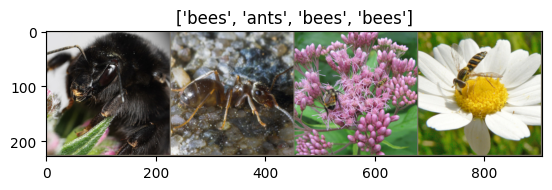

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [16]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [17]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [18]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [19]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

C:\Users\luccas.marim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\luccas.marim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\luccas.marim/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████|

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [22]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [24]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/3 Loss: 0.6990 Acc: 0.5246        
Phase: validation   Epoch: 1/3 Loss: 0.6429 Acc: 0.6536        
Phase: train Epoch: 2/3 Loss: 0.6134 Acc: 0.7008        
Phase: validation   Epoch: 2/3 Loss: 0.5389 Acc: 0.8235        
Phase: train Epoch: 3/3 Loss: 0.5652 Acc: 0.7418        
Phase: validation   Epoch: 3/3 Loss: 0.4484 Acc: 0.8497        
Training completed in 2m 44s
Best test loss: 0.4484 | Best test accuracy: 0.8497


In [25]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

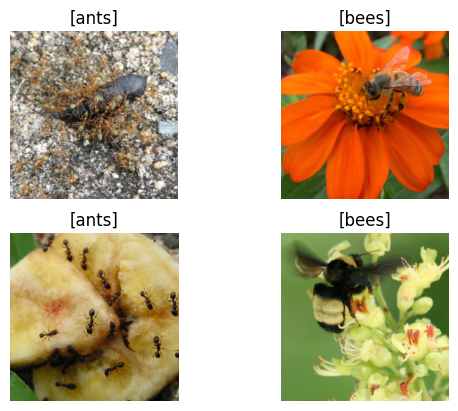

In [30]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

### Fim de Quantum Transfer Learning. Estou usando esta parte de baixo como rascunho


In [35]:
from qiskit.circuit.library import NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw()

┌──────────┐ ░                                                 »
q_0: ┤ Ry(θ[0]) ├─░──────■──────────────────────────────────────────»
     ├──────────┤ ░ ┌────┴─────┐                                    »
q_1: ┤ Rz(θ[1]) ├─░─┤ Rx(θ[6]) ├─────■───────────────────────■──────»
     ├──────────┤ ░ └──────────┘┌────┴─────┐            ┌────┴─────┐»
q_2: ┤ Ry(θ[2]) ├─░─────────────┤ Rx(θ[7]) ├─────■──────┤ Rx(θ[9]) ├»
     ├──────────┤ ░             └──────────┘┌────┴─────┐└──────────┘»
q_3: ┤ Rz(θ[3]) ├─░─────────────────────────┤ Rx(θ[8]) ├────────────»
     ├──────────┤ ░                         └──────────┘            »
q_4: ┤ Ry(θ[4]) ├─░─────────────────────────────────────────────────»
     ├──────────┤ ░                                                 »
q_5: ┤ Rz(θ[5]) ├─░─────────────────────────────────────────────────»
     └──────────┘ ░                                                 »
«                                                                      
«q_0: ─────────────────────────────────────────────────────────────────
«                                                                      
«q_1: ─────────────────────────────────────────────────────────────────
«                                                                      
«q_2: ──────■─────────────────────────■────────────────────────────────
«     ┌─────┴─────┐             ┌─────┴─────┐                          
«q_3: ┤ Rx(θ[10]) ├──────■──────┤ Rx(θ[12]) ├──────■───────────────────
«     └───────────┘┌─────┴─────┐└───────────┘┌─────┴─────┐             
«q_4: ─────────────┤ Rx(θ[11]) ├─────────────┤ Rx(θ[13]) ├──────■──────
«                  └───────────┘             └───────────┘┌─────┴─────┐
«q_5: ────────────────────────────────────────────────────┤ Rx(θ[14]) ├
«                                                         └───────────┘

In [37]:
from qiskit.circuit.library import ZZFeatureMap
qc_zz = ZZFeatureMap(6, reps=1, insert_barriers=True)
qc_zz.decompose().draw()

┌───┐ ░ ┌─────────────┐                                               »
q_0: ┤ H ├─░─┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤ ░ ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├─░─┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤ ░ ├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├─░─┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤ ░ ├─────────────┤                                          └───┘»
q_3: ┤ H ├─░─┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     ├───┤ ░ ├─────────────┤                                               »
q_4: ┤ H ├─░─┤ P(2.0*x[4]) ├───────────────────────────────────────────────»
     ├───┤ ░ ├─────────────┤                                               »
q_5: ┤ H ├─░─┤ P(2.0*x[5]) ├───────────────────────────────────────────────»
     └───┘ ░ └─────────────┘                                               »
«                                                    »
«q_0: ──────────────────────────────────■─────────■──»
«                                       │         │  »
«q_1: ──────────────────────────────────┼────■────┼──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  »
«q_2: ┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──»
«     └──────────────────────────────┘└───┘└───┘┌─┴─┐»
«q_3: ──────────────────────────────────────────┤ X ├»
«                                               └───┘»
«q_4: ───────────────────────────────────────────────»
«                                                    »
«q_5: ───────────────────────────────────────────────»
«                                                    »
«                                                         »
«q_0: ───────────────────────────────────────■─────────■──»
«                                            │         │  »
«q_1: ──────────────────────────────────■────┼────■────┼──»
«     ┌──────────────────────────────┐┌─┴─┐  │    │    │  »
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──┼────┼────┼──»
«     ├──────────────────────────────┤└───┘┌─┴─┐┌─┴─┐  │  »
«q_3: ┤ P(2.0*(π - x[0])*(π - x[3])) ├─────┤ X ├┤ X ├──┼──»
«     └──────────────────────────────┘     └───┘└───┘┌─┴─┐»
«q_4: ───────────────────────────────────────────────┤ X ├»
«                                                    └───┘»
«q_5: ────────────────────────────────────────────────────»
«                                                         »
«                                                              »
«q_0: ───────────────────────────────────────■──────────────■──»
«                                            │              │  »
«q_1: ──────────────────────────────────■────┼─────────■────┼──»
«                                       │    │         │    │  »
«q_2: ──────────────────────────────────┼────┼────■────┼────┼──»
«     ┌──────────────────────────────┐┌─┴─┐  │  ┌─┴─┐  │    │  »
«q_3: ┤ P(2.0*(π - x[1])*(π - x[3])) ├┤ X ├──┼──┤ X ├──┼────┼──»
«     ├──────────────────────────────┤└───┘┌─┴─┐└───┘┌─┴─┐  │  »
«q_4: ┤ P(2.0*(π - x[0])*(π - x[4])) ├─────┤ X ├─────┤ X ├──┼──»
«     └──────────────────────────────┘     └───┘     └───┘┌─┴─┐»
«q_5: ────────────────────────────────────────────────────┤ X ├»
«                                                         └───┘»
«                                                              »
«q_0: ────────────────────────────────────────────■────────────»
«                                                 │            »
«q_1: ───────────────────────────────────────■────┼─────────■──»
«                                            │    │         │  »
«q_2: ──────────────────────────────────■────┼────┼────■────┼──»
«     ┌──────────────────────────────┐┌─┴─┐  │    │    │    │  »
«q_3: ┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├──┼────┼────┼────┼──»
«     ├──────────────────────────────┤└───┘┌─┴─┐  │  ┌─┴─┐  │  »
«q_4: ┤ P(2.0*(π - x[1])*(π - x[4])) ├─────┤ X ├──┼──┤ X ├──┼──»
«     ├───────

In [15]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit

n=5  #Quantidade de qubits disponiveis

theta_list = ParameterVector('θ', length=n)
rho_list = ParameterVector('ρ',length=n)

qc = QuantumCircuit(n)

for i in range(n):
    qc.rz(theta_list[i], i)
    qc.ry(rho_list[i], i)

qc.draw()

┌──────────┐┌──────────┐
q_0: ┤ Rz(θ[0]) ├┤ Ry(ρ[0]) ├
     ├──────────┤├──────────┤
q_1: ┤ Rz(θ[1]) ├┤ Ry(ρ[1]) ├
     ├──────────┤├──────────┤
q_2: ┤ Rz(θ[2]) ├┤ Ry(ρ[2]) ├
     ├──────────┤├──────────┤
q_3: ┤ Rz(θ[3]) ├┤ Ry(ρ[3]) ├
     ├──────────┤├──────────┤
q_4: ┤ Rz(θ[4]) ├┤ Ry(ρ[4]) ├
     └──────────┘└──────────┘

C:\Users\luccas.marim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pennylane_lightning\lightning_qubit.py:893: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(
C:\Users\luccas.marim\AppData\Local\Temp\ipykernel_30460\2774245125.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


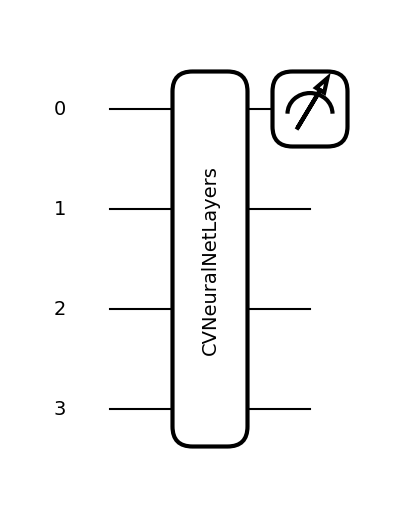

In [50]:
from pennylane.templates.layers import CVNeuralNetLayers
from pennylane import numpy as np
import pennylane as qml

dev = qml.device('lightning.qubit', wires=4)

shapes = CVNeuralNetLayers.shape(n_layers=2, n_wires=4)
weights = [np.random.random(shape) for shape in shapes]

@qml.qnode(dev)
def circuit():
  CVNeuralNetLayers(*weights, wires=[0, 1, 2, 3])
  return qml.expval(qml.X(0))

fig, ax = qml.draw_mpl(circuit)()
fig.show()

In [31]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
# Nesse layer adicionamos gates de Hadamard para usar as propriedades de superposição de nosso modelo.

def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
# Nesse layer adicionamos gates de rotação em torno do eixo Y.

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

(<Figure size 600x500 with 1 Axes>, <Axes: >)


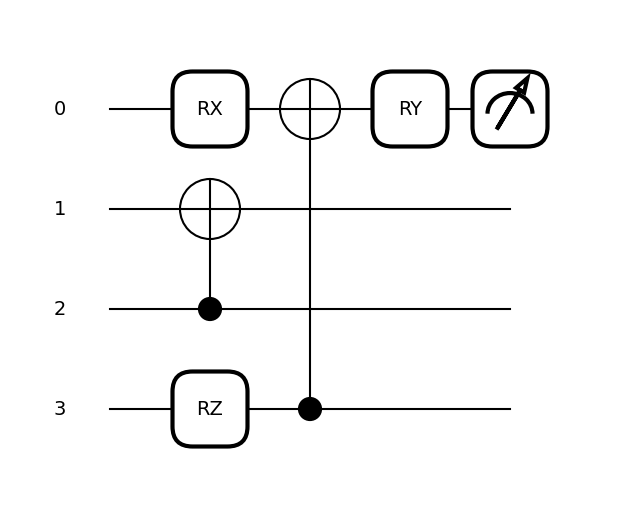

In [5]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=4)
weights = np.array([[0.1, -2.1, 1.3]])

@qml.qnode(dev)
def circuit1(weights):
    qml.RandomLayers(weights=weights, wires=range(4))
    return qml.expval(qml.PauliZ(0))

print(qml.draw_mpl(circuit1, expansion_strategy="device")(weights))

In [4]:
@qml.qnode(dev)
def circuit(weights, seed=None):
    qml.RandomLayers(weights=weights, wires=range(4), seed=seed)
    return qml.expval(qml.PauliZ(0))

print(qml.draw(circuit, expansion_strategy="device")(weights, seed=97))

NameError: name 'weights' is not defined

(<Figure size 1300x500 with 1 Axes>, <Axes: >)


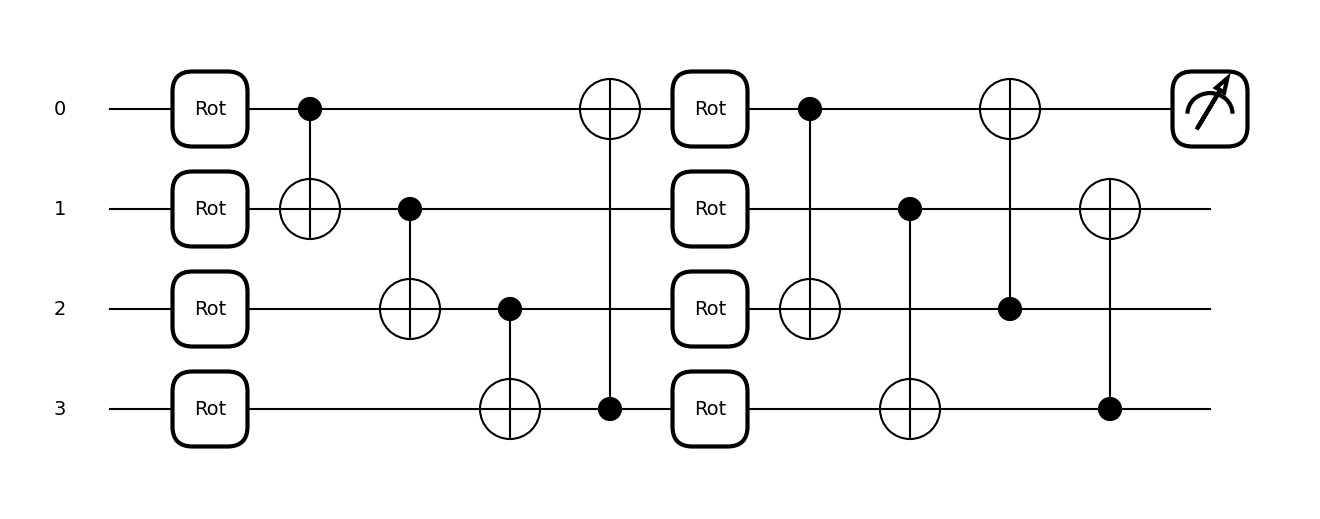

In [101]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return qml.expval(qml.PauliZ(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(size=shape)

print(qml.draw_mpl(circuit, expansion_strategy="device")(weights))

In [117]:
import pennylane as qml
from math import pi

n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def circuit(init_weights, weights):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]

init_weights = [pi, pi, pi]
weights_layer1 = [[0., pi],
                  [0., pi]]
weights_layer2 = [[pi, 0.],
                  [pi, 0.]]
weights = [weights_layer1, weights_layer2]

#shapes = qml.SimplifiedTwoDesign.shape(n_layers=2, n_wires=2)
#weights = [np.random.random(size=shape) for shape in shapes]

print(qml.draw_mpl(circuit, expansion_strategy="device")(weights)(init_weights))

TypeError: circuit() missing 1 required positional argument: 'weights'

In [12]:
import pennylane as qml
from math import pi

n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def circuit(init_weights, weights):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]

init_weights = [pi, pi, pi]
weights_layer1 = [[0., pi], [0., pi]]
weights_layer2 = [[pi, 0.], [pi, 0.]]

weights = [weights_layer1, weights_layer2]

#print(qml.draw_mpl(circuit, expansion_strategy="device")(init_weights, weights))

In [154]:
import pennylane as qml
from math import pi

n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def circuit(init_weights, weights):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]

init_weights = [pi, pi, pi]
weights_layer1 = [[0., pi],
                  [0., pi]]
weights_layer2 = [[pi, 0.],
                  [pi, 0.]]
weights = [weights_layer1, weights_layer2]

(<Figure size 800x500 with 1 Axes>, <Axes: >)


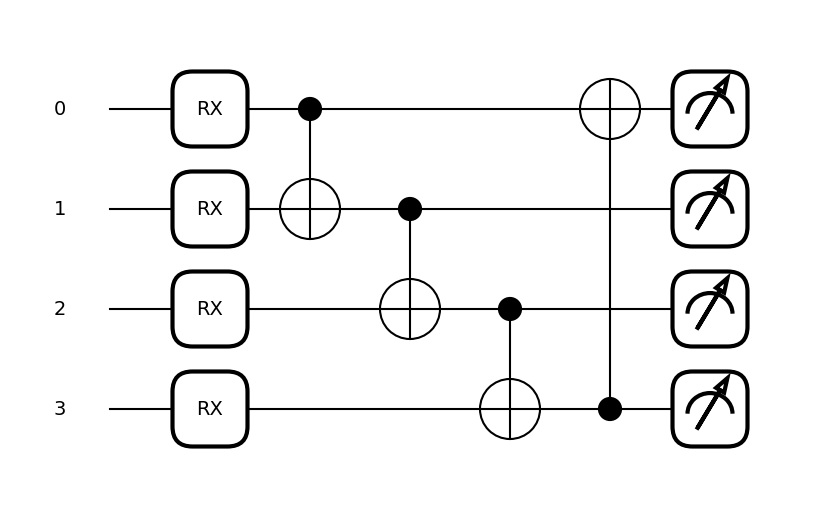

In [163]:
import pennylane as qml
from math import pi

n_wires = 4
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def circuit(weights):
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]


print(qml.draw_mpl(circuit, expansion_strategy="device")([[pi,pi,pi,pi]]))

In [16]:
import pennylane as qml
from math import pi

n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def circuit(init_weights, weights):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]

a = 0.
init_weights = [pi, pi, pi]
weights_layer1 = [[a, pi],
                  [a, pi]]
weights_layer2 = [[pi, a]
                  [pi, a]]
weights = [weights_layer1, weights_layer2]

fig, ax = qml.draw_mpl(circuit)(init_weights,weights)
fig.show()

<>:16: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:16: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
C:\Users\luccas.marim\AppData\Local\Temp\ipykernel_138208\2084182872.py:16: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  weights_layer2 = [[pi, a]
C:\Users\luccas.marim\AppData\Local\Temp\ipykernel_138208\2084182872.py:16: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  weights_layer2 = [[pi, a]
C:\Users\luccas.marim\AppData\Local\Temp\ipykernel_138208\2084182872.py:16: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  weights_layer2 = [[pi, a]


TypeError: list indices must be integers or slices, not tuple

Layer: 1
Pesos iniciais: 
1.61 2.41 1.82 2.22 0.26 2.00 1.92 1.43 

Layer: 2
Pesos atualizados: 
3.71 2.46 2.01 1.02 1.97 2.19 1.13 1.69 

Layer: 3
Pesos atualizados: 
4.96 0.80 4.70 5.02 4.85 3.70 3.67 0.48 

(<Figure size 1700x400 with 1 Axes>, <Axes: >)

Circuito correspondente ao seed: 7550

Estado resultado do circuito:  state(wires=[])


C:\Users\luccas.marim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\qutip\qobj.py:303: UserWarning: Initializing Qobj from unsupported type: <class 'pennylane.measurements.measurements.MeasurementProcess'>
  warnings.warn("Initializing Qobj from unsupported type: %s" %


ZeroDivisionError: float division by zero

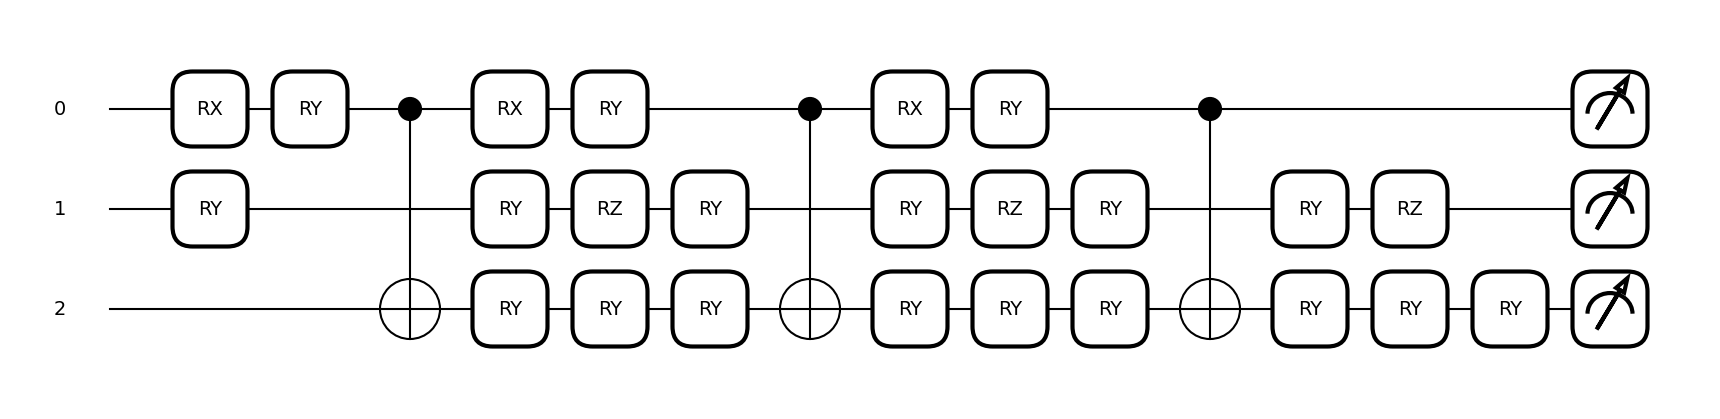

In [61]:
import pennylane as qml
from pennylane import numpy as np
from random import randint, uniform
from math import pi

n_wires = 4
n_layers = 2

dev = qml.device('default.qubit', wires=n_wires)


weights = np.array([[uniform(0,2*pi), 
                     uniform(0,2*pi), 
                     uniform(0,2*pi), 
                     uniform(0,2*pi),
                     uniform(0,2*pi), 
                     uniform(0,2*pi), 
                     uniform(0,2*pi), 
                     uniform(0,2*pi),
                     ]])

print("Layer: {}".format(1))
print("Pesos iniciais: ")
for i in weights[0]:
    print("{:.2f} ".format(float(i)), end='')
print("")
print("")

ket = None

@qml.qnode(dev)
def circuit(weights, seed=None):

    global ket

    qml.RandomLayers(weights=weights, wires=range(n_wires), seed=seed)

    for i in range(0,n_layers):
        weights = np.array([[uniform(0,2*pi), 
            uniform(0,2*pi), 
            uniform(0,2*pi), 
            uniform(0,2*pi), 
            uniform(0,2*pi), 
            uniform(0,2*pi), 
            uniform(0,2*pi), 
            uniform(0,2*pi),
                     ]])
        
        print("Layer: {}".format(i+2))

        print("Pesos atualizados: ")
        for i in weights[0]:
            print("{:.2f} ".format(float(i)), end='')
        print("\n")


        qml.RandomLayers(weights=weights, wires=range(n_wires), seed=seed)

    #return qml.expval(qml.PauliZ(0))
    ket = qml.state()
    return ket


seed = randint(1, 9999)


print(qml.draw_mpl(circuit, expansion_strategy="device")(weights, seed))

print("\nCircuito correspondente ao seed: {}".format(seed))

#ket = circuit(weights, seed)
print("\nEstado resultado do circuito: ", ket)



import qutip

def compute_Q_ptrace(ket, N):

    ket = qutip.Qobj(ket, dims=[[2]*(N), [1]*(N)]).unit()    #Transforma nosso KET em uma matriz
    #print('KET=  ', ket)   Podemos verificar se a conversão esta correta
    entanglement_sum = 0
    for k in range(N):
        #print('value of n', k, 'PTrace: ',ket.ptrace([k])**2 )
        rho_k_sq = ket.ptrace([k])**2
        entanglement_sum += rho_k_sq.tr()  
   
    Q = 2*(1 - (1/N)*entanglement_sum)
    return Q


print("\nCircuito gerando estado com grau de emaranhamento: ",compute_Q_ptrace(ket, n_wires))


